In [164]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import gensim
from gensim.models import KeyedVectors


import pandas as pd
f_train = open('./data/train.dat',encoding="utf-8")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [165]:
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.corpus.reader.wordnet import VERB, NOUN, ADJ, ADV
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = stopwords.words('english')
eng_stop_words=list(ENGLISH_STOP_WORDS)
my_stop_words=['make','guy','really','think','watch','look','know','work','thing','want','start',
               'doesn','lot','end','tell','year','get','eat','tfw','away','boy','girl','real','leave','action',
               'come','name','series','movie','actor','story','film','htm','plot','trailer',
               'woman','man','way','do','say','don','character','time','get','people','point','fact',
               'scene','go','didn','let','isn','men','actress','age','flick','hollywood','actually',
               'title','camera','hand','hour','director','feel','cast','act','play','set']
eng_stop_words.extend(my_stop_words)
stopwords_dict = Counter(stop_words)
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def stop_word_rem_and_lemmatization(text):
    lemm_text=[]
    from nltk.tokenize import word_tokenize
    #stop_words_cleaned_text=[word for word in text.split() if word not in stopwords_dict]
    
    
    for word,tag in pos_tag(text.split()):
        lemm_text.append(lemmatizer.lemmatize(word, get_wordnet_pos(tag)))
    lemm_text=[word for word in lemm_text if word not in eng_stop_words]
    return " ".join(lemm_text)

    

In [166]:
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.stem import PorterStemmer    
from nltk.corpus import stopwords
import re
from autocorrect import Speller

ratings=[]

def preprocessData(file):
        processed_text=[]
       
        for line in file:
            #remove <br /> tags and newline characters from text
            sentence = line.replace('<br />','').strip('\n').split('\t')
            
            if(len(sentence)==2):
                ratings.append(sentence[0])
                #convert text to lowercase
                sentence=sentence[1].lower()
            else:
                sentence=sentence[0].lower()
                
            Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
            
            #limit repetation of characters to two eg: Greeeeaaaatttt will be converted to Greeaatt
            Formatted_text = Pattern_alpha.sub(r"\1\1", sentence) 
            Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
            Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
            sentence = re.sub(' {2,}',' ', Combined_Formatted)
            
            #Remove words with special characters, eg: G-R-E-A-T will be transformed to great.
            sentence=re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', sentence) 
            
            # remove punctuation marks and numbers
            for ch in punctuation+'0123456789$%-':
                sentence = sentence.replace(ch,' ')
            
            #remove all characters less than or equal to two characters
            sentence=re.sub(r'\b\w{1,2}\b', '', sentence)
               
            
            #Text lemmatization and stop words removal
            sentence=stop_word_rem_and_lemmatization(sentence)
            processed_text.append(sentence)
            
        return processed_text
            

In [167]:
train_data=preprocessData(f_train)
print(train_data[2])

interesting actual event place civil war vermont attention regret view haven read raid incident curious rebel pull enjoy historical era major complaint confederate uniform good acting little stiff like old mash potato teeth wounded soldier fetch hound little strange overall descent


In [168]:
import pandas as pd

#load the data into dataframes
d = {'Rating':ratings,'Review':train_data}
df = pd.DataFrame(d)
df.head()


,Rating,Review
0,-1,bruce willis worth good skip television plunk ...
1,-1,slow molasses january alaska togeather preview...
2,-1,interesting actual event place civil war vermo...
3,-1,painfully obvious brilliant spoof naked gun ho...
4,+1,mixed bag concept good tense nice twist slow s...


In [169]:
# split the training dataset into 80% training and 20% testing sets so that we can find the best model for given data
import numpy as np
index = df.index
rand_num=np.random.randn(len(index))
df['random_number'] = rand_num
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]
print(len(train))
print(len(test))


19668
5332


In [170]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_cnt = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix_cnt = vectorizer_cnt.fit_transform(train['Review'])
test_matrix_cnt = vectorizer_cnt.transform(test['Review'])
print(train_matrix_cnt.shape)

(19668, 58630)


In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
vectorizer_tf=TfidfVectorizer(norm = 'l2',min_df = 0, use_idf = True, smooth_idf = False, sublinear_tf = True,
                             ngram_range=(1,2), max_features = 15000,token_pattern=r'\b\w+\b')

train_matrix_tf_idf = vectorizer_tf.fit_transform(train['Review'])
test_matrix_tf_idf = vectorizer_tf.transform(test['Review'])

print((train_matrix_tf_idf.shape))

(19668, 15000)


In [196]:
from sklearn.feature_selection import chi2,SelectKBest
from matplotlib import pyplot as plt
#chi2score = chi2(train_matrix, y_train)[0]
ch2 = SelectKBest(chi2, k=7000)
train_matrix_chi2 = ch2.fit_transform(train_matrix_tf_idf,train['Rating'])
test_matrix_chi2 = ch2.transform(test_matrix_tf_idf)
print(train_matrix_chi2.shape)

(19668, 7000)


In [173]:
X_train_vectorizors=[train_matrix_cnt,train_matrix_tf_idf,train_matrix_chi2]
X_test_vectorizors=[test_matrix_cnt,test_matrix_tf_idf,test_matrix_chi2]
X_labels=['Count Vectorizor','TF-IDF','TF-IDF + CHI2 ']


In [174]:
y_train = train['Rating']
y_test = test['Rating']

In [175]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
acc_list=[]
prec_list=[]
f1_list=[]
acc_all_model=[]
k=1900
cat_names = ['True -ve','False +ve','False -ve','True +ve']

for i in range(3):
    X_train = X_train_vectorizors[i]
    X_test = X_test_vectorizors[i]
    print("----------------------------------------------")
    print("FOR VECTORIZOR "+X_labels[i])

    for m in [#'manhattan',
              'euclidean','cosine']:

        classifier = KNeighborsClassifier(n_neighbors=k,algorithm='auto',metric=m) #Using brute-force algorithm for quicker computation.
        classifier.fit(X_train, y_train) #Fitting the built-in sklearn classifier on our training data
        predicted_label = classifier.predict(X_test) #Making the classifier to predict on the previously unseen test data.

        confusion_mat = confusion_matrix(y_test, predicted_label)
        class_report = classification_report(y_test, predicted_label)
        class_report_dict = classification_report(y_test, predicted_label,output_dict=True)
        acc_list.append({m:np.round(class_report_dict['accuracy']*100,2)})
        f1_list.append({m:np.round(class_report_dict['weighted avg']['f1-score']*100,2)})
        prec_list.append({m:np.round(class_report_dict['weighted avg']['precision']*100,2)})
        if(i==2 and m=='cosine'):
            acc_all_model.append({'knn':np.round(class_report_dict['accuracy']*100,2)})
        print("\nClassification Report for metric = {} is:\n".format(m))
        print(class_report)

----------------------------------------------
FOR VECTORIZOR Count Vectorizor

Classification Report for metric = euclidean is:

              precision    recall  f1-score   support

          +1       0.56      0.98      0.71      2642
          -1       0.92      0.24      0.39      2690

    accuracy                           0.61      5332
   macro avg       0.74      0.61      0.55      5332
weighted avg       0.74      0.61      0.55      5332


Classification Report for metric = cosine is:

              precision    recall  f1-score   support

          +1       0.82      0.66      0.73      2642
          -1       0.72      0.86      0.78      2690

    accuracy                           0.76      5332
   macro avg       0.77      0.76      0.76      5332
weighted avg       0.77      0.76      0.76      5332

----------------------------------------------
FOR VECTORIZOR TF-IDF

Classification Report for metric = euclidean is:

              precision    recall  f1-score   su

In [176]:
print(acc_list)
print(acc_all_model)

[{'euclidean': 60.77}, {'cosine': 75.98}, {'euclidean': 84.11}, {'cosine': 84.11}, {'euclidean': 66.0}, {'cosine': 84.81}]
[{'knn': 84.81}]


In [177]:
#comparision of accuracy of different knn models
df_acc=pd.DataFrame(acc_list)
df_acc = df_acc.apply(lambda x: pd.Series(x.dropna().values))
df_acc.index=X_labels
df_acc.style.highlight_max(color = 'lightblue', axis = 0)


,euclidean,cosine
Count Vectorizor,60.770000,75.980000
TF-IDF,84.110000,84.110000
TF-IDF + CHI2,66.000000,84.810000


In [178]:
df_prec=pd.DataFrame(prec_list)
df_prec = df_prec.apply(lambda x: pd.Series(x.dropna().values))
df_prec.index=X_labels
df_prec.style.highlight_max(color = 'lightblue', axis = 0)

,euclidean,cosine
Count Vectorizor,73.960000,76.930000
TF-IDF,84.120000,84.120000
TF-IDF + CHI2,79.240000,84.810000


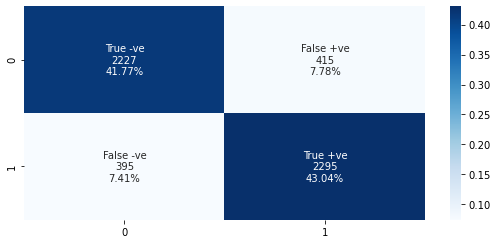

In [179]:
# confusion matrix for TF-IDF+ chi square and cosine distance

import seaborn as sns
cat_names = ['True -ve','False +ve','False -ve','True +ve']
cat_counts = ["{0:0.0f}".format(value) for value in
                confusion_mat.flatten()]
cat_percentages = ["{0:.2%}".format(value) for value in
                     confusion_mat.flatten()/np.sum(confusion_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(cat_names,cat_counts,cat_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_mat/np.sum(confusion_mat), annot=labels,fmt='', cmap='Blues')

In [197]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_matrix_chi2,y_train)
predictions_lr = lr.predict(test_matrix_chi2)

In [198]:
print(classification_report(predictions_lr,y_test))
class_report_dict_lr = classification_report(y_test, predictions_lr,output_dict=True)
acc_all_model.append({'logistic Regression':np.round(class_report_dict_lr['accuracy']*100,2)})

              precision    recall  f1-score   support

          +1       0.91      0.86      0.88      2815
          -1       0.85      0.91      0.88      2517

    accuracy                           0.88      5332
   macro avg       0.88      0.88      0.88      5332
weighted avg       0.88      0.88      0.88      5332



In [182]:
from sklearn import svm
#svm = svm.SVC(probability=True, kernel="linear")
#svm.fit(train_matrix_chi2,y_train)
#prediction_svm = svm.predict(test_matrix_chi2)

In [183]:
#print(classification_report(prediction_svm,y_test))
#class_report_dict_svm = classification_report(y_test, prediction_svm,output_dict=True)
#acc_all_model.append({'SVM':np.round(class_report_dict_svm['accuracy']*100,2)})

              precision    recall  f1-score   support

          +1       0.90      0.86      0.88      2784
          -1       0.85      0.90      0.87      2548

    accuracy                           0.88      5332
   macro avg       0.88      0.88      0.88      5332
weighted avg       0.88      0.88      0.88      5332



In [184]:
from sklearn.naive_bayes import MultinomialNB
nby = MultinomialNB()
nby.fit(train_matrix_chi2,y_train)
predictions_nbm=nby.predict(test_matrix_chi2)
print(classification_report(predictions_nbm,y_test))
class_report_dict_nb = classification_report(y_test, prediction_svm,output_dict=True)
acc_all_model.append({'Naive Bayes':np.round(class_report_dict_nb['accuracy']*100,2)})

              precision    recall  f1-score   support

          +1       0.89      0.85      0.87      2773
          -1       0.84      0.89      0.86      2559

    accuracy                           0.87      5332
   macro avg       0.87      0.87      0.87      5332
weighted avg       0.87      0.87      0.87      5332



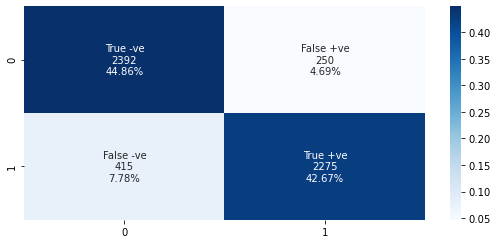

In [185]:
confusion_mat_lr = confusion_matrix(y_test, predictions_lr)
import seaborn as sns
cat_names = ['True -ve','False +ve','False -ve','True +ve']
cat_counts = ["{0:0.0f}".format(value) for value in
                confusion_mat_lr.flatten()]
cat_percentages = ["{0:.2%}".format(value) for value in
                     confusion_mat_lr.flatten()/np.sum(confusion_mat_lr)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(cat_names,cat_counts,cat_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_mat_lr/np.sum(confusion_mat_lr), annot=labels,fmt='', cmap='Blues')

In [186]:
print(acc_all_model)
classifiers_keys = set().union(*(d.keys() for d in acc_all_model))
classifier_pers=[]
for index in range(len(acc_all_model)):
    for key in acc_all_model[index]:
        classifier_pers.append(acc_all_model[index][key])

#classifier_pers= list().extend(*(d.values() for d in acc_all_model))
print(classifier_pers)
print(classifiers_keys)

[{'knn': 84.81}, {'logistic Regression': 87.53}, {'SVM': 87.66}, {'Naive Bayes': 87.66}]
[84.81, 87.53, 87.66, 87.66]
{'Naive Bayes', 'knn', 'SVM', 'logistic Regression'}


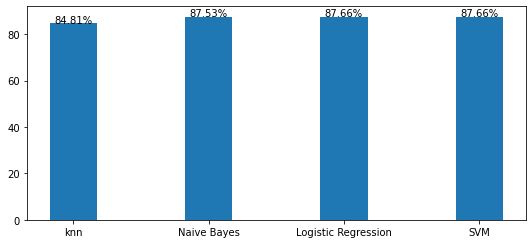

In [188]:
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
x = ['knn','Naive Bayes','SVM','Logistic Regression']
y = classifier_pers

width = 0.35
fig, ax = plt.subplots()

pps = ax.bar(x, y, width, align='center')

for p in pps:
   height = p.get_height()
   ax.text(x=p.get_x() + p.get_width() / 2, y=height+.10,
      s="{}%".format(height),
      ha='center')

plt.show()

In [189]:
# Logistic Regression along with tf-id+chi-square yeilded the best result
# We will use the above combination to predict test data
f_test = open('./data/test.dat',encoding="utf-8")
test_data=preprocessData(f_test)



In [190]:
vectorizer_tf_test=TfidfVectorizer(norm = 'l2',min_df = 0, use_idf = True, smooth_idf = False, sublinear_tf = True,
                             ngram_range=(1,2), max_features = 40000,token_pattern=r'\b\w+\b')

train_matrix_tf_idf_act = vectorizer_tf_test.fit_transform(train_data)
test_matrix_tf_idf_act = vectorizer_tf_test.transform(test_data)
print(train_matrix_tf_idf_act.shape)

ch2_act = SelectKBest(chi2, k=30000)
train_matrix_chi2_act = ch2_act.fit_transform(train_matrix_tf_idf_act, ratings)
test_matrix_chi2_act = ch2_act.transform(test_matrix_tf_idf_act)
print(train_matrix_chi2_act.shape[1])
#k=1900
#knnClassifier = KNeighborsClassifier(n_neighbors=k,algorithm='auto',metric='cosine')
#knnClassifier.fit(train_matrix_chi2_act, ratings)
#predictions = knnClassifier.predict(test_matrix_chi2_act)
lr_clf = LogisticRegression()
lr_clf.fit(train_matrix_chi2_act,ratings)
predictions_lr_clf = lr_clf.predict(test_matrix_chi2_act)

f_test.close()

(25000, 15000)
4970


In [191]:
print(predictions_lr_clf)

['+1' '+1' '+1' ... '+1' '+1' '-1']


In [192]:
predict_file=open("./data/predictions_lr_07.dat","w")
for val in predictions_lr_clf:
    predict_file.write(val+"\n")
predict_file.close()